### Theoretical Part

##### Hypothesis Testing: the problem of multiple comparisons 

Given that:
- $\alpha$ is the Type I error for each test
- $\beta$ is the Type II error
- $1 - \beta$ is the power

a) P($m^{th}$ experiment gives significant result | $m$ experiments lacking power to reject $H_0$) = $\alpha (1 - \beta)^{m-1}$,

where $(1 - \beta)^{m-1}$ is the probability that the first $m - 1$ experiments correctly conclude that the result is not significant, and $\alpha$ is the probability that the next experiment will yield a Type I error. We can rephrase this event as
> Experiment 1 correctly rejects $H_0$ **AND** Experiment 2 correctly rejects $H_0$ **AND ... AND** Experiment $m$ yields a Type I error.

b) P(at least one significant result | $m$ experiments lacking power to reject $H_0$) = $m \alpha$. 

We can rephrase this event as 
> Experiment 1 yields a Type I error **OR** Experiment 2 yields a Type I error **OR ... OR** Experiment $m$ yields a Type I error.

which can be translated into an $m$-fold addition of the Type I error probability $\alpha$.

##### Bias and unfairness in Interleaving experiments

We present a situation where interleaving should produce a preference for one of the two ranking lists but 
it fails to do so and it assigns equal expected winning probability to both rankings.

Let $d_3$ be the only relevant document, i.e. the only document the user will click on.
In list A, $d_3$ is ranked as third, whereas $d_3$ is in the second position of Ranking A. Therefore, Ranking B is expected to win more often than Ranking B. Consider, however, the following rankings and the four lists that can be generated using Team Draft Interleaving:

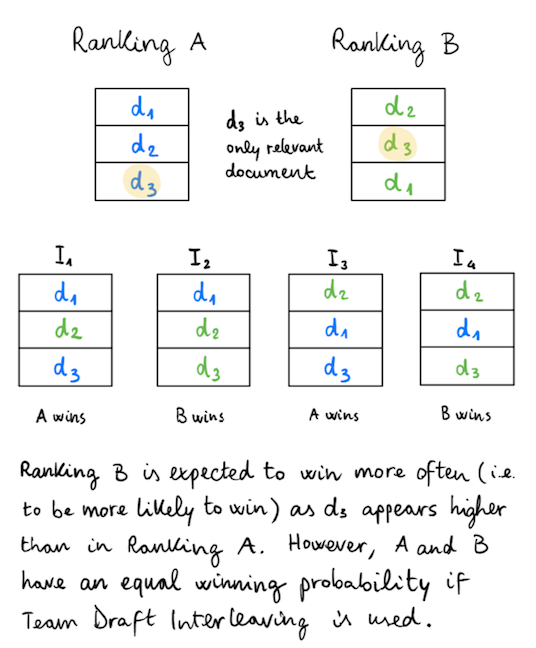

In [1]:
from IPython.display import Image
Image("interleaving_bias.png")

In [1]:
# Step 1: Simulate Rankings of Relevance for E and P

import itertools

relevance = [0, 1, 2]  # 0: N, 1: R, 2: HR
combinations = list(itertools.product(relevance, repeat=5))
ranking_pairs = list(itertools.product(combinations, repeat=2))

# delete ratings that are the same for both  
for i,k in enumerate(ranking_pairs):
    if k[0] == k[1]:
        del ranking_pairs[i]
k = 10
for pair in ranking_pairs[:k]:
    print(pair)
    
    

((0, 0, 0, 0, 0), (0, 0, 0, 0, 1))
((0, 0, 0, 0, 0), (0, 0, 0, 0, 2))
((0, 0, 0, 0, 0), (0, 0, 0, 1, 0))
((0, 0, 0, 0, 0), (0, 0, 0, 1, 1))
((0, 0, 0, 0, 0), (0, 0, 0, 1, 2))
((0, 0, 0, 0, 0), (0, 0, 0, 2, 0))
((0, 0, 0, 0, 0), (0, 0, 0, 2, 1))
((0, 0, 0, 0, 0), (0, 0, 0, 2, 2))
((0, 0, 0, 0, 0), (0, 0, 1, 0, 0))
((0, 0, 0, 0, 0), (0, 0, 1, 0, 1))


In [2]:
def average_precision(query_judgement):
    l = []
    rel_docs = 0
    
    for i, judgement in enumerate(query_judgement, start=1):
        if judgement != 0:
            rel_docs += 1
            l.append(rel_docs / i)
            
    if rel_docs == 0:
        return 0
    
    return sum(l) / rel_docs       

In [3]:
from math import log

def dcg(query_judgement, k):
    query_judgement = list(query_judgement)[:k]
    dcg = 0
    
    for i, judgement in enumerate(query_judgement, start=1):
        dcg += (2 ** judgement - 1) / log(i + 1, 2)
        
    return dcg

def ndcg(query_judgement, k):
    perfect_ordering = sorted(query_judgement, reverse=True)
    perfect_score = dcg(perfect_ordering, k)
    
    if perfect_score == 0:
        return 0
    
    return dcg(query_judgement, k) / perfect_score

In [4]:
max_rel = 2  # ad-hoc for 3 different judgements
satisfaction_probs = [(2 ** rel - 1) / 2 ** max_rel for rel in range(3)]

def err(query_judgement):
    sat_probs = []
    
    for rel in query_judgement:
        sat_probs.append(satisfaction_probs[rel])
        
    err = 0
    
    for i in range(1, len(query_judgement) + 1):
        prod = sat_probs[i - 1]
        
        for j in range(1, i):
            prod *= 1 - sat_probs[j]
        
        err += prod / i
    
#     if err == 0:
#         return len(query_judgement)
    
    return err

In [5]:
max_rel = 2  # ad-hoc for 3 different judgements
satisfaction_probs = [(2 ** rel - 1) / 2 ** max_rel for rel in range(3)]

def err(query_judgement):
    sat_probs = []
    
    for rel in query_judgement:
        sat_probs.append(satisfaction_probs[rel])
        
    err = 0
    prod = 1
    
    for i in range(1, len(query_judgement) + 1):
        rel_prob = sat_probs[i - 1]
        
        err += prod * rel_prob / i
        prod *= 1 - rel_prob
            
#     if err == 0:
#         return len(query_judgement)
    
    return err

In [6]:
print(1/ err(ranking_pairs[11][1]))

7.6800000000000015


In [7]:
ranking_pairs[242][1]

(0, 0, 0, 0, 0)

In [9]:
import random


def team_draft_interleaving(a, b):
    '''
    Implementation of the team draft interleaving algorithm
    Args:
        a, b: list
    Return:
        interleaved_list, chosen_list
    '''
    final_list = []
    chosen = []  # list containing a/b values

    while (len(a) > 0 and len(b) > 0):
        choose_a = bool(random.getrandbits(1))

        current_a = a[0]
        current_b = b[0]

        to_add = list(set([current_a, current_b]))
        
        if not choose_a:
            to_add = to_add[::-1]
            
        final_list += to_add

        if current_b in a: a.remove(current_b)
        if current_a in b: b.remove(current_a)

        if len(a) > 0: del a[0]
        if len(b) > 0: del b[0]

    return final_list, chosen

In [10]:

a = [1, 2, 3]
b = [2, 3, 1]

print(team_draft_interleaving(a, b))

([1, 2, 3], [])
